In [1]:
import numpy as np
import pandas as pd

from xgboost import XGBClassifier, plot_importance

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.dpi'] = 100
# plt.style.use('seaborn-bright')

/Users/adam/miniforge3/envs/cnn/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
X = pd.read_csv('../csv/initial_variables.csv', index_col='date', parse_dates=True, infer_datetime_format=True)
X = X[['close', 'volume', 'bond_2yr', 'bond_3mt', 'rsi_fast_d', 'williams_r', 'mom', 'bond_5yr', 'rsi', 'bond_10yr']]
# X = X[['close', 'volume', 'bond_2yr', 'bond_3mt', 'rsi_fast_d', 'williams_r', 'mom', 'bond_5yr', 'rsi', 'bond_10yr']]

y = (X['close'].pct_change().shift(-1) > 0).astype(int)

In [3]:
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X, y, test_size=0.333, shuffle=False)

In [4]:
model = XGBClassifier()
model.fit(X_train_df, y_train_df, eval_metric='rmse')

/Users/adam/miniforge3/envs/cnn/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/adam/miniforge3/envs/cnn/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=10,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

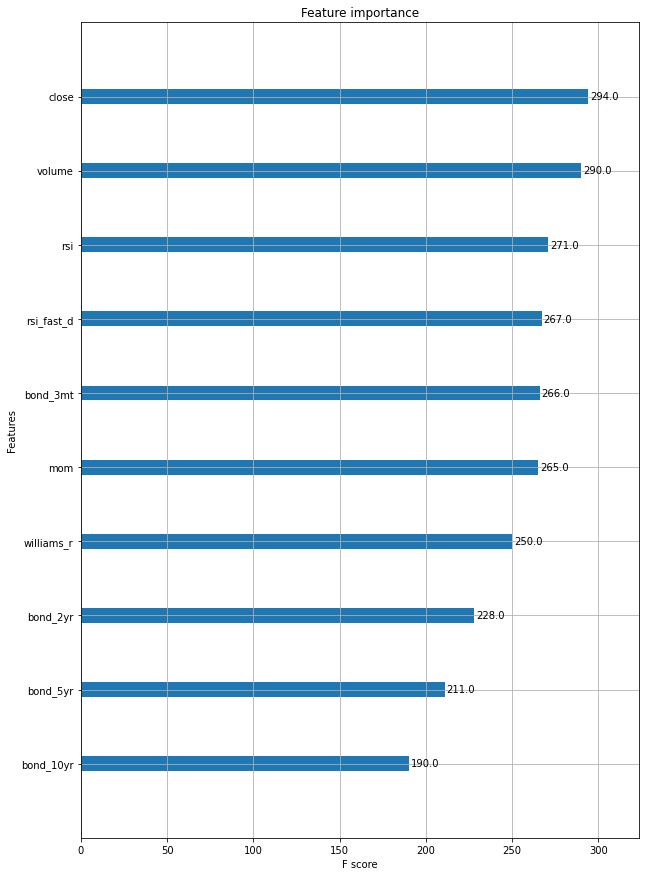

In [5]:
ax = plot_importance(model)
ax.figure.set_size_inches(10, 15)
plt.show()

In [6]:
scaler = MinMaxScaler().fit(X_train_df)
X_train_scaled = scaler.transform(X_train_df)
X_test_scaled = scaler.transform(X_test_df)

In [7]:
X_train = np.array(X_train_scaled)
y_train = np.array(y_train_df)
X_test = np.array(X_test_scaled)
y_test = np.array(y_test_df)

# make predictions for test data and evaluate
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Fit model using each importance as a threshold
thresholds = np.sort(model.feature_importances_)

for thresh in thresholds:

	# select features using threshold
	selection = SelectFromModel(model, threshold=thresh, prefit=True)
	select_X_train = selection.transform(X_train)

	# train model
	selection_model = XGBClassifier(use_label_encoder=False, eval_metric='rmse')
	selection_model.fit(select_X_train, y_train)
	
	# eval model
	select_X_test = selection.transform(X_test)
	y_pred = selection_model.predict(select_X_test)
	predictions = [round(value) for value in y_pred]
	accuracy = accuracy_score(y_test, y_pred)
	print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Accuracy: 44.99%
Thresh=0.091, n=10, Accuracy: 46.78%
Thresh=0.094, n=9, Accuracy: 47.37%
Thresh=0.094, n=8, Accuracy: 49.05%
Thresh=0.095, n=7, Accuracy: 48.81%
Thresh=0.099, n=6, Accuracy: 48.81%
Thresh=0.100, n=5, Accuracy: 47.73%
Thresh=0.105, n=4, Accuracy: 49.05%
Thresh=0.105, n=3, Accuracy: 51.31%
Thresh=0.106, n=2, Accuracy: 53.46%
Thresh=0.111, n=1, Accuracy: 55.13%


In [8]:
# Thresh=0.015, n=23, Accuracy: 52.74%
# best_model = SelectFromModel(model, threshold=0.005, prefit=True)
# select features using threshold
selection = SelectFromModel(model, threshold=0.015, max_features=1, prefit=True)
select_X_train = selection.transform(X_train)

# train model
selection_model = XGBClassifier(use_label_encoder=False, eval_metric='rmse')
selection_model.fit(select_X_train, y_train)

# eval model
select_X_test = selection.transform(X_test)
y_pred = selection_model.predict(select_X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, y_pred)

In [9]:
accuracy

0.5513126491646778

In [10]:
trading_df = y_test_df.rename('test').to_frame()
trading_df['pred'] = y_pred
trading_df['close'] = X_test_df['close']
trading_df = trading_df.reindex(columns=['close', 'test', 'pred'])

In [11]:
trading_df.head()

,close,test,pred
date,,,
2019-04-04,2879.389893,1,1
2019-04-05,2892.739990,1,1
2019-04-08,2895.770020,0,1
2019-04-09,2878.199951,1,1
2019-04-10,2888.209961,1,1


In [12]:
trading_df.to_csv('../csv/trading.csv')

In [13]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2012-08-01 to 2022-08-01
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   close       2516 non-null   float64
 1   volume      2516 non-null   int64  
 2   bond_2yr    2516 non-null   float64
 3   bond_3mt    2516 non-null   float64
 4   rsi_fast_d  2516 non-null   float64
 5   williams_r  2516 non-null   float64
 6   mom         2516 non-null   float64
 7   bond_5yr    2516 non-null   float64
 8   rsi         2516 non-null   float64
 9   bond_10yr   2516 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 216.2 KB
